In [1]:
!pip install nengo --quiet
!pip install nengo-dl --quiet
!pip install nengo-loihi --quiet
!pip install nengo-extras==0.5.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 2.1 MB/s eta 0:00:00


A small intro, LMU can be thought as replacement of LSTMs but in Brain fashion ⚡

11490434/11490434 [==============================] - 0s 0us/step


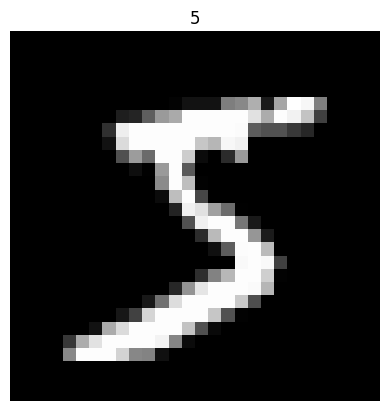

In [2]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo.utils.filter_design import cont2discrete
import numpy as np
import tensorflow as tf

import nengo_dl

# set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# reshape the labels to rank 3 (as expected in Nengo)
train_labels = train_labels[:, None, None]
test_labels = test_labels[:, None, None]

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()

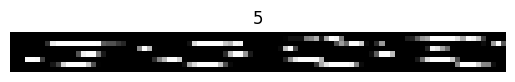

In [3]:
# flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()


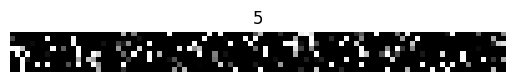

In [4]:
# apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()

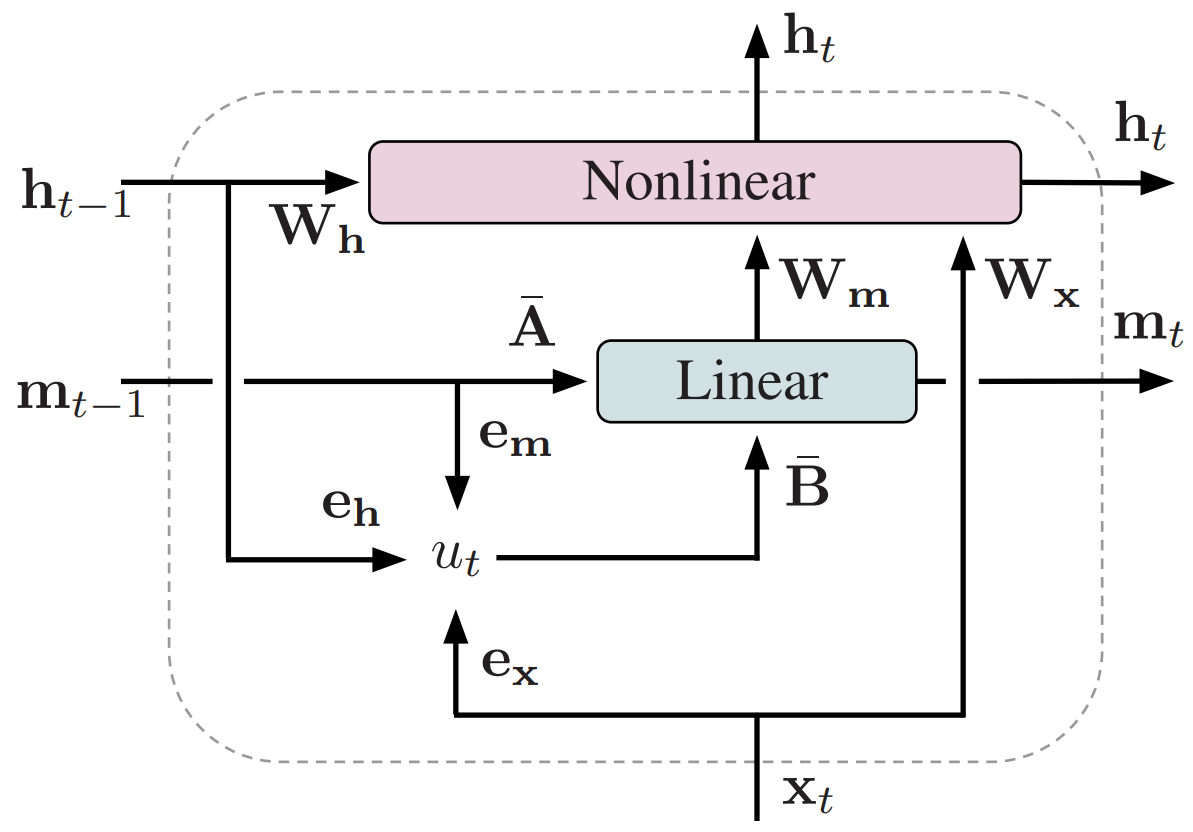

In [5]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

            # compute u_t from the above diagram. we have removed e_h and e_m as they
            # are not needed in this task.
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )

In [6]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(train_images.shape[-1]))

    # lmu cell
    lmu = LMUCell(
        units=212,
        order=256,
        theta=train_images.shape[1],
        input_d=train_images.shape[-1],
    )
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False

    # dense linear readout
    out = nengo.Node(size_in=10)
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
    p = nengo.Probe(out)

In [7]:
do_training = False

with nengo_dl.Simulator(net, minibatch_size=100, unroll_simulation=16) as sim:
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=["accuracy"],
    )

    test_acc = sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    print(f"Initial test accuracy: {test_acc * 100:.2f}%")

    if do_training:
        sim.fit(train_images, train_labels, epochs=10)
        sim.save_params("./lmu_params")
    else:
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1UbVJ4u6eQkyxIU9F7yScElAz2p2Ah2sP",
            "lmu_params.npz",
        )
        sim.load_params("./lmu_params")

    test_acc = sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               
Initial test accuracy: 7.98%
Final test accuracy: 96.15
